# TDA  with Python using the Gudhi Library 

# Building simplicial complexes from distance matrices

**Authors :** F. Chazal and B. Michel

In [1]:
import numpy as np
import pandas as pd
import pickle as pickle
import gudhi as gd  
from pylab import *
%matplotlib inline

TDA typically aims at extracting topological signatures from a point cloud in $\mathbb R^d$ or in a general metric space. [Simplicial complexes](https://en.wikipedia.org/wiki/Simplicial_complex) are used in computational geometry to infer topological signatures from data.

This tutorial explains how to build [Vietoris-Rips complexes](https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex)  and [alpha complexes](https://en.wikipedia.org/wiki/Alpha_shape#Alpha_complex) from a matrix of pairwise distances.

## Vietoris-Rips filtration defined from a matrix of distances 

The [$\alpha$-Rips complex](https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex) of a metric space $\mathbb X$ is an [abstract simplicial complex](https://en.wikipedia.org/wiki/Abstract_simplicial_complex) that can be defined by forming a simplex for every finite subset of $\mathbb X$ that has diameter at most $\alpha$.  

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/600px-VR_complex.svg.png)

 
## Protein binding dataset

The data we will be studying in this notebook represents configurations of protein binding. This example is borrowed from Kovacev-Nikolic et al. [[1]](https://arxiv.org/pdf/1412.1394.pdf).

The paper compares closed and open forms of the maltose-binding protein (MBP), a large biomolecule containing $370$ amino-acid residues. The analysis is not based on geometric distances in $\mathbb R^3$ but on a metric of *dynamical distances* defined by

$$ D_{ij} = 1 - |C_{ij}|, $$

where $C$ is the correlation matrix between residues. Correlation matrices between residues can be found at this [link](https://www.researchgate.net/publication/301543862_corr). We are greatful to the authors for sharing data !

The next statments load the $14$ correlation matrices with pandas:

In [2]:
path_file = "./datasets/Corr_ProteinBinding/"
files_list = [
    '1anf.corr_1.txt', 
    '1ez9.corr_1.txt', 
    '1fqa.corr_2.txt', 
    '1fqb.corr_3.txt', 
    '1fqc.corr_2.txt', 
    '1fqd.corr_3.txt', 
    '1jw4.corr_4.txt', 
    '1jw5.corr_5.txt', 
    '1lls.corr_6.txt', 
    '1mpd.corr_4.txt', 
    '1omp.corr_7.txt', 
    '3hpi.corr_5.txt', 
    '3mbp.corr_6.txt', 
    '4mbp.corr_7.txt'
]
corr_list = [
    pd.read_csv(
        path_file + u, 
        header = None, 
        delim_whitespace = True
    ) for u in files_list
]

The object `corr_list` is a list of $14$ correlation matrices. We can iterate in the list to compute the matrix of distances associated to each configuration:

In [3]:
dist_list = [1 - np.abs(c) for c in corr_list]

Let's print out the first lines of the first distance matrix:

In [4]:
D = dist_list[0]
D.head()

,0,1,2,3,4,5,6,7,8,9,...,360,361,362,363,364,365,366,367,368,369
0,0.000000,0.076200,0.171364,0.378207,0.461747,0.493499,0.478665,0.432338,0.568455,0.639504,...,0.694159,0.723059,0.660802,0.614051,0.660601,0.686334,0.640850,0.617944,0.695108,0.748451
1,0.076200,0.000000,0.122763,0.233837,0.350744,0.406213,0.425202,0.381799,0.541636,0.646580,...,0.817461,0.844610,0.781266,0.740222,0.793586,0.808770,0.754748,0.730646,0.804961,0.848953
2,0.171364,0.122763,0.000000,0.084642,0.131528,0.148980,0.162259,0.164105,0.333175,0.480605,...,0.782234,0.813481,0.718610,0.666239,0.742311,0.740322,0.667525,0.653546,0.742430,0.766030
3,0.378207,0.233837,0.084642,0.000000,0.045478,0.132107,0.217299,0.293902,0.494307,0.675635,...,0.913930,0.929677,0.853475,0.813717,0.868041,0.856491,0.797437,0.781044,0.842591,0.858435
4,0.461747,0.350744,0.131528,0.045478,0.000000,0.059280,0.146850,0.297257,0.511751,0.734412,...,0.967195,0.979578,0.889375,0.841519,0.895967,0.874522,0.804538,0.779865,0.841695,0.849836


## Vietoris-Rips filtration of Protein binding distance matrix

The `RipsComplex()` function creates a [$1$-skeleton](https://en.wikipedia.org/wiki/N-skeleton) from the point cloud (see the [GUDHI documentation](http://gudhi.gforge.inria.fr/python/latest/rips_complex_user.html) for details on the syntax).

In [5]:
skeleton_protein = gd.RipsComplex(
    distance_matrix = D.values, 
    max_edge_length = 0.8
) 

The `max_edge_length` parameter is the maximal diameter: only the edges of length less vers this value are included in the one skeleton graph. 

Next, we create the Rips simplicial complex from this one-skeleton graph. This is a filtered Rips complex which filtration function is exacly the diameter of the simplices. We use the `create_simplex_tree()` function:

In [6]:
Rips_simplex_tree_protein = skeleton_protein.create_simplex_tree(max_dimension = 2)

The `max_dimension` parameter is the maximum dimension of the simplices included in the the filtration. The object returned by the function is a simplex tree, of dimension 2 in this example:

In [7]:
Rips_simplex_tree_protein.dimension()

2

We can use the fonctionalites of the simplex tree object to describe the Rips filtration.
For instance we can check that the 370 points of the first distance matrix are all vertices of the Vietoris-Rips filtration:

In [8]:
Rips_simplex_tree_protein.num_vertices()

370

The number of simplices in a Rips complex increases very fast with the number of points and the dimension. There is more than on million of simplexes in the Rips complex:

In [9]:
Rips_simplex_tree_protein.num_simplices()

1626660

Note that this is actually the number of simplices in the "last" Rips complex of the filtration, namely with parameter $\alpha=$ `max_edge_length=`0.8. 

Let's compute the list of simplices in the Rips complex with the `get_filtration()` function:


In [11]:
filt_Rips_protein = list(Rips_simplex_tree_protein.get_filtration())
print(len(filt_Rips_protein))

1626660


In [12]:
for splx in filt_Rips_protein[0:400] :
    print(splx)

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([16], 0.0)
([17], 0.0)
([18], 0.0)
([19], 0.0)
([20], 0.0)
([21], 0.0)
([22], 0.0)
([23], 0.0)
([24], 0.0)
([25], 0.0)
([26], 0.0)
([27], 0.0)
([28], 0.0)
([29], 0.0)
([30], 0.0)
([31], 0.0)
([32], 0.0)
([33], 0.0)
([34], 0.0)
([35], 0.0)
([36], 0.0)
([37], 0.0)
([38], 0.0)
([39], 0.0)
([40], 0.0)
([41], 0.0)
([42], 0.0)
([43], 0.0)
([44], 0.0)
([45], 0.0)
([46], 0.0)
([47], 0.0)
([48], 0.0)
([49], 0.0)
([50], 0.0)
([51], 0.0)
([52], 0.0)
([53], 0.0)
([54], 0.0)
([55], 0.0)
([56], 0.0)
([57], 0.0)
([58], 0.0)
([59], 0.0)
([60], 0.0)
([61], 0.0)
([62], 0.0)
([63], 0.0)
([64], 0.0)
([65], 0.0)
([66], 0.0)
([67], 0.0)
([68], 0.0)
([69], 0.0)
([70], 0.0)
([71], 0.0)
([72], 0.0)
([73], 0.0)
([74], 0.0)
([75], 0.0)
([76], 0.0)
([77], 0.0)
([78], 0.0)
([79], 0.0)
([80], 0.0)
([81], 0.0)
([82], 0.0)
([83], 0.0)
([

The integers represent the points in the metric space: the vertex [2] corresponds to the point decribed by the second raw (or the second column) in the distance matrix `mat_dist0`. 

The filtration value is the diameter of the simplex, which is zero for the vertices of course. The first edge in the filtration is [289, 290], these two points are the two closest points according to `mat_dist0`, at distance 0.015 of each other. 

### How to define an Alpha complex from a matrix of distance ?

The [alpha complex filtration](https://en.wikipedia.org/wiki/Alpha_shape#Alpha_complex) of a point cloud in $\mathbb R^p$ is a filtered simplicial complex constructed from the finite cells of a [Delaunay Triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).

In our case, the data does not belong to euclideen space $\mathbb R^p$ and we are not in position to directly compute a Delaunay Triangulation in the metric space, using  the pairwise distances.

The aim of [Multidimensional Scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) (MDS) methods is precisely to find a representation of $n$ points in a space $\mathbb R^p$ that preserves as well as possible the pairwise distances between the $n$ points in the original metric space. The are several versions of MDS algorithms, the most popular ones are available in the [sckit-learn library](https://scikit-learn.org/stable/index.html), see this [documention](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

Let's compute a (classical) MDS representation of the matrix `mat_dist0` in $\mathbb R^3$:

In [13]:
from sklearn.manifold import MDS
 
embedding = MDS(n_components=3,dissimilarity='precomputed')
X_transformed = embedding.fit_transform(mat_dist0)
X_transformed.shape

(370, 3)

Now we can represent this configuration, for instance on the two first axes:

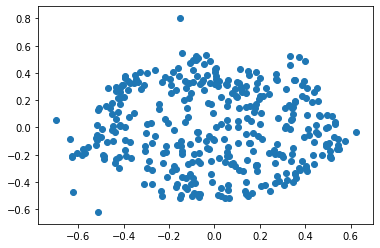

In [14]:
fig = plt.figure()
plt.scatter(X_transformed[:, 0], X_transformed[:, 1],label='MDS');

Of course you should keep in mind that MDS provides an embedding of the data in $\mathbb R^p$ that **approximatively** preserves the distance matrix.

The main advantage of Alpha complexes is that they contain  less simplices than Rips complexes do and so it can be a better option than Rips complexes. As subcomplexes of the Delaunay Triangulation complex, an alpha complex is a geometric simpicial complex.

The `AlphaComplex()` function directly computes the simplex tree representing the Alpha complex:

In [15]:
alpha_complex = gd.AlphaComplex(points=X_transformed)

In [16]:
st_alpha = alpha_complex.create_simplex_tree()

The point cloud `X_transformed` belongs to $\mathbb R^3$ and so does the Alpha Complex:

In [17]:
st_alpha.dimension()

3

As for the Rips complex, the 370 points are all vertices of the Alpha complex :

In [18]:
print(st_alpha.num_vertices())

370


Note that the number of simplexes in the Alpha complex is much smaller then for the Rips complex we computed before:


In [19]:
print(st_alpha.num_simplices())

9253


###  References

[1] Using persistent homology and dynamical distances to analyze protein binding, V. Kovacev-Nikolic, P. Bubenik, D. Nikolic and G. Heo. Stat Appl Genet Mol Biol 2016 [arxiv link](https://arxiv.org/pdf/1412.1394.pdf).